In [23]:
import sys
from ephys import rasters, core, events
import matplotlib.pyplot as plt
import numpy as np
import math
%pylab inline
#reload(rasters)
import numpy.matlib as matlib

Populating the interactive namespace from numpy and matplotlib


/home/srrudrar/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['interactive', 'f', 'rate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
from ephys import core, events, rasters
import numpy as np
import matplotlib.pyplot as plt
from oe_pipeline import mdaio
from importlib import reload

In [25]:
import pyMNE_functions as func

In [26]:
#block_path = '/mnt/cube/nyoni-raw/test_data/201901300906-B970-block-9-AP-1250-ML-750-Z-1750'
#block_path = '/mnt/cube/mturvz/analysis/sorted_experiments/0227/B1146/blocks/201902271608-B1146-block-2-AP-2300-ML-400-Z-1550/2019-02-27_16-08-48'
#block_path = '/mnt/cube/Nasim/1_Receptive Field_MNE/2_B952/B952_2_Pen01_Lft_AP750_ML1750__Site01_Z1500__B952_cat_P01_S01_2'
block_path = '/mnt/cube/srrudrar/mansort01/Pen01_Lft_AP750_ML1750__Site01_Z1100__B952_cat_P01_S01_1'
 

reload(events)
spikes = core.load_spikes(block_path)
stims = core.load_events(block_path, 'Stimulus')
print(stims)
trials = events.load_trials(block_path)
fs = core.load_fs(block_path)
clusters = core.load_clusters(block_path)
#clusters['quality'] = ['good'] * 43

     codes  recording                         text  time_samples
0      244          0                 b'13.326999'         80847
1        1          0  b'm_211_s_25_song_60sec_01'         80847
2      244          0                 b'78.207749'       1378462
3        1          0                 b'G124-1 -1'       1378462
4      244          0                b'148.965199'       2793611
..     ...        ...                          ...           ...
195      1          0                b'G107-17_01'     138689118
196    244          0               b'7022.003099'     140254369
197      1          0               b'165_s_02_01'     140254369
198    244          0               b'7100.174699'     141817801
199      1          0                 b'G124-1 -1'     141817801

[200 rows x 4 columns]


In [27]:
print(trials)

    recording  time_samples                  stimulus  stimulus_end  response  \
0           0         80152  m_211_s_25_song_60sec_01       1280152       NaN   
1           0       1378271                 G124-1 -1       2715450       NaN   
2           0       2793056                 G124-1 -1       4130235       NaN   
3           0       4233521               165_s_02_01       5714172       NaN   
4           0       5798394               165_s_02_01       7279045       NaN   
..        ...           ...                       ...           ...       ...   
95          0     136106152            m_497_17_s1 -1     137306152       NaN   
96          0     137404286  m_211_s_25_song_60sec_01     138604286       NaN   
97          0     138688825                G107-17_01     140134847       NaN   
98          0     140253448               165_s_02_01     141734099       NaN   
99          0     141817593                 G124-1 -1     143154772       NaN   

    response_time  conseque

In [28]:
stims = trials['stimulus'].unique()
nstims = len(stims)

In [29]:
stims

array(['m_211_s_25_song_60sec_01', 'G124-1 -1', '165_s_02_01',
       'm_497_17_s1 -1', 'G107-17_01'], dtype=object)

# Get rasters

In [30]:
def plot_raster_cell_stim(spikes, trials, clusterID,
                          stim, period, rec, fs, ax=None, stim_ref='stim', **kwargs):
    '''
    Plots a spike raster for a single cell and stimulus
    Parameters
    ------
    spikes : pandas dataframe
        spike dataframe from core
    trials : pandas dataframe
        trials dataframe from events
    clusterID : int
        ID number of the cluster you wish to make the raster for
    stim : str
        Name of the stimulus you wish to plot cluster's activity for
    period : list of floats
        Time window for the raster:
        [Seconds_pre_stimulus_onset, Seconds_post_stimulus_end]
    rec : int
        Recording ID
    fs : float
        Sampling rate
    plot_params : dict
        Drawing parameters:
        'spike_linewidth' - linewidth of ticks for spikes
        'tick_linewidth' - linewidth of ticks for event markers
        'spike_color' - color of spike ticks
        'tick_color' - color of event ticks
    ax : Matplotlib axes handle, optional
        Axes on which to produce the raster.  Default is to use gca
    kwargs :
        keyword arguments are passed to the do_raster method
    '''
    from ephys.spiketrains import get_spiketrain
    stim_trials = trials[trials['stimulus'] == stim]
    ntrials = len(stim_trials)
    stim_starts = stim_trials['time_samples'].values
    stim_ends = stim_trials['stimulus_end'].values
    stim_end_seconds = np.unique((stim_ends - stim_starts) / fs)[0]
    if stim_ref == 'stim':
        window = [period[0], stim_end_seconds + period[1]]
    elif stim_ref == 'abs':
        window = [period[0], period[1]]
    raster_data = []
    for trial, start in enumerate(stim_starts):
        sptrain = get_spiketrain(rec, start, clusterID, spikes, window, fs)
        raster_data.append(sptrain)
    #ax = do_raster(raster_data, window, [0, stim_end_seconds], ntrials, ax, **kwargs)
    return raster_data, stim_end_seconds

In [31]:
### get raster data for all clusters
n_units = len(clusters)
raster_data = []
stim_end_seconds = [[None]*len(stims)]*n_units

for i in range(len(clusters)):
    r_cluster = []
    for j in range(len(stims)):           
        r_data, stim_end_seconds[i][j] = plot_raster_cell_stim(spikes, trials, clusters['cluster'][i], stims[j], [-2, 2], 0, 30000.0)
        r_cluster.append(r_data)
    raster_data.append(r_cluster)

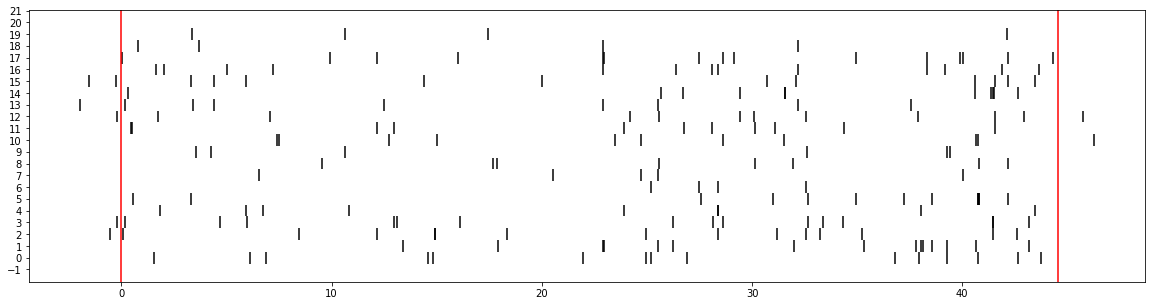

In [46]:
### change stim_end_seconds for different cells
ntrials = len(trials)
spike_linewidth=1.5
spike_color='k'
ax = plt.gca()
ax.set_yticks(range(-1, ntrials-1))
ax.figure.set_size_inches(20, 5)
xposition = [0, stim_end_seconds[9][1]]
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='-')
ax.eventplot(raster_data[9][1], linewidths=spike_linewidth, colors=spike_color)

# Get stimulus information

In [33]:
import pandas as pd
d = []
for s in stims:
    ind = np.where(trials['stimulus'] == s)[0]
    d.append({'name' : s, 
              'start_times' : [trials['time_samples'][i] for i in ind], 
              'end_times' : [trials['stimulus_end'][i] for i in ind],
              'trial_start' : [trials['time_samples'][i] for i in ind], 
              'trial_end' : [trials['stimulus_end'][i] for i in ind],
              'ntrials' : (list(trials['stimulus'])).count(s)})
stim_data = pd.DataFrame(d)

# Get toe data, toes

In [34]:
### make cluster_stim_data dataframe, one for each cluster
### name, ntrials, stim_start_times, stim_end_times, trial_start_times, trial_end_times, toes
d_stim = []
for i in range(len(clusters)):
    d_stim.append({'name':list(stims), 
                   'ntrials':stim_data['ntrials'].tolist(), 
                   'stim_start_times':stim_data['start_times'].tolist(), 
                   'stim_end_times':stim_data['end_times'].tolist(), 
                   'trial_start_times':stim_data['trial_start'].tolist(), 
                   'trial_end_times':stim_data['trial_end'].tolist(), 
                   'toes':raster_data[i]})
cluster_stim_data = pd.DataFrame(d_stim)
cluster_stim_data = cluster_stim_data.to_dict(orient='index')



In [35]:
### make toe_data pandas dataframe, one for each cluster
### cluster id, sort class, fs, stims, all_spikes
d1 = []
for i in range(len(clusters)):
    ind = np.where(np.array(spikes['cluster']) == i+1)[0]
    d1.append({'id':clusters['cluster'][i], 
               'sort_class':clusters['quality'][i], 
               'fs':30000, 
               'stims':cluster_stim_data[i], 
               'all_spikes':[spikes['time_samples'][j] for j in ind]})
toe_data = pd.DataFrame(d1)
toe_data = toe_data.to_dict(orient='id')

# Stim prep

In [36]:
from ipywidgets import interact, interactive, fixed

from glob import glob
from joblib import Parallel, delayed

import imp
folder_utils = imp.load_source('folder_utils', r'/mnt/cube/srrudrar/folder_utils.py')
ensure_folder_exists = folder_utils.ensure_folder_exists

import h5py, os
import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import librosa.filters
import numpy as np

import scipy as sp
from scipy import signal
from scipy.signal import butter, lfilter, spectrogram
from scipy.io import wavfile
import IPython.display

import matplotlib.pyplot as plt

In [37]:
### Write a better way to get spectrograms
### Get spectrogram
import os
stim_folder = '/mnt/cube/Nasim/1_Receptive Field_MNE/2_B952/stim/'

print(os.listdir(stim_folder))
T = []
P = []
P_all = []
nfft = 128

for i in range(len(stims)):
    rate, data = wavfile.read(os.path.join(stim_folder, stims[i]+'.wav'))
    #spec = spectrogram(data, hparams)
    (f, t_stim, P_stim) = sp.signal.spectrogram(data, fs = 48000, nfft = 128, 
                                            window = np.hanning(nfft), noverlap = 0.5*nfft)
    #P_stims, freqs, bins, im = plt.specgram(data[:,0], nfft = 128, fs = 48000, noverlap = 0.5*nfft)
    P.append(P_stim)
    T.append(t_stim)
P_all = np.hstack(P)

['m_211_s_25_song_60sec_01.wav', '165_s_02_01.wav', 'G124-1 -1.wav', 'm_497_17_s1 -1.wav', 'G107-17_01.wav']


In [38]:
Nf = 16       # number of frequency bands in STRF
Nlags = 20    # number of times/lags
order   = 2   # order of MNE model to fit: order 1=linear part of equation,  order=2: linear and non linear parts
fittype = 0   # to intialize: 0 for regular fitting, 1 for random fitting  
njack   = 4
Nd = 4

In [39]:
### Please write better code than this ! :/
from scipy import stats
P_all_mean = np.empty([16,np.shape(P_all)[1]])
for i in range(16):
    P_all_mean[i,:] = np.mean((20 * np.log(P_all))[4*i:(4*(i+1))-1 , :], axis = 0)

tsamples = int(np.shape(P_all)[1]/8)
P_mean = np.empty([16,tsamples])
for i in range(tsamples):
    P_mean[:,i] = np.mean(P_all_mean[: , 8*i:(8*(i+1))-1], axis = 1)

In [40]:
stimulus = stats.zscore(P_mean)
[Ndim, Nsamples] = np.shape(stimulus)

In [41]:
if Nlags > 1:
    Nsamples_lag = Nsamples - Nlags + 1    #total length of stimulus minus 19 time bins (16000=16119-(20-1))
    Ndimtotal = Ndim * Nlags           #16x20
    stim = stimulus[:,0:Nsamples_lag]
    for i in range(1,Nlags):
        stim = np.vstack((stim, stimulus[:,i:Nsamples_lag+i])) 
else:
    stim = stimulus        

In [43]:
clusters

,cluster,quality
0,2,MUA
1,3,Good
2,4,unsorted
3,5,Noise
4,6,MUA
5,7,Good
6,9,MUA
7,10,Noise
8,11,MUA
9,13,MUA


# Resp prep

In [48]:
cellnum = 13
toedata_ind = pd.Index(list(clusters['cluster'])).get_loc(cellnum)

In [49]:
toes_stim = []
for i in range(len(stims)):
    toes_stim.append(toe_data[toedata_ind]['stims']['toes'][i])

In [50]:
### create trial average of every 5 trials for all stim 
### how many trials in this case
Nlags = 20
Nf = 16

In [51]:
resp = []
for s in range(len(stims)):
    timetobin = np.shape(P[s])[1] / T[s][-1]
    resp_stim = np.zeros(shape=(stim_data['ntrials'][s] , np.shape(P[s])[1]))
    #resp_stim = [[None]*np.shape(P[s])[1]]*stim_data['ntrials'][s]
    for k in range(stim_data['ntrials'][s]):
        toes_this_trial = []
        toes_this_trial = toes_stim[s][k]
        for m in range(len(toes_this_trial)):
            if toes_this_trial[m] > 0 and  toes_this_trial[m] * timetobin < np.shape(P[s])[1]:
                resp_stim[k , int(round(toes_this_trial[m])*timetobin)] = resp_stim[k , int(round(toes_this_trial[m])*timetobin)] + 1
                #resp_1(k,round(A_1(m_1).*timetobin_1)) = resp_1(1,round(A_1(m_1).*timetobin_1)) + 1;
    resp.append(list(resp_stim))

In [52]:
for i in range(len(stims)):
    if len(resp[i]) == 2:
        resp[i].append(resp[i][1])
    if len(resp[i]) == 1:
        resp[i].append(resp[i][0])
        resp[i].append(resp[i][0])

In [53]:
resp_123 = [None]*3
for i in range(3):
    resp_123[i] = np.hstack(resp[j][i] for j in range(len(stims)))

/home/srrudrar/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
### downsample stimuli
resp_123_downsize = np.empty([3,tsamples])
for j in range(3):
    for i in range(tsamples):
        resp_123_downsize[j][i] = np.mean(resp_123[j][8*i:(8*(i+1))-1])

In [55]:
a = np.mean(resp_123_downsize, axis=0)
response = a[Nlags-1:]/(np.amax(a[Nlags:]))

# Run MNE

In [56]:
masterstim = np.transpose(stim)    #104040x320
masterresp = response    #104040x1
master_samples = len(masterstim)

In [57]:
njack = 4
Ntest = int(master_samples/njack)

In [58]:
#####
jack = 3
Ntest = int(master_samples/njack)    #  rounds the Ntest to the nearest integers 
ind = range(jack*Ntest,(jack+1)*Ntest)
teststim = masterstim[jack*Ntest : (jack+1)*Ntest, :]
testresp = masterresp[jack*Ntest : (jack+1)*Ntest]
trainstim = np.delete(masterstim, ind, axis = 0) 
trainresp = np.delete(masterresp, ind)

### Start clock (add this)
# Start optimization: look for highest P(resp/stim)=1/(1+exp(a+sh+s^t*J*s)^-1
display('Starting optimization')
#tic()
#celltype = '';  #ignore this

'Starting optimization'

In [59]:
#MNEfit(stim, resp, teststim, testresp, celltype, cellnum, jack, order, Nd, fittype);
[Nsamples_2,Ndim_2] = np.shape(trainstim)
psp = np.mean(trainresp)   #constant parameter a
avg = (np.dot(np.transpose(trainstim),trainresp))/Nsamples_2  # h: linear
avgs = np.concatenate(([psp],avg), axis = 0)

if order>1:
    a = np.transpose(matlib.repmat(trainresp,Ndim_2,1))
    b = np.multiply(a,trainstim)
    avgsqrd = np.dot(np.transpose(trainstim),b)/Nsamples_2  #Ndim x Ndim (320x320)
    avgsqrd = avgsqrd.flatten()
    avgs = np.concatenate((avgs,avgsqrd), axis = 0)

pstart = np.empty(np.shape(avgs))
pstart[0] = math.log((1/avgs[0]) - 1)     #pstart(a)
random = np.random.rand(Ndim_2)
pstart[1:Ndim_2+1] = 0.001*((2*random)-1)
if order>1:
    random1 = np.random.rand(Ndim_2,Ndim_2)
    temp = 0.001*((2*random1)-1)          #pstart(J)
    pstart[Ndim_2+1:] = (temp+np.transpose(temp)).reshape([1,Ndim_2**2])
    del temp

In [60]:
#def log_loss(self, p, stim, resp):
def log_loss(p, *args):
    #get p into correct form:
    p = np.matrix(p)
    stim, resp, order = args
    
    #get number of samples and dimensionality of stimulus
    Nsamples = np.size(stim,0)
    Ndim = np.size(stim,1)
    
    #unpack p: (var names match names in Fitzgerald paper)
    a = p[0,0]
    h = p[0,1:Ndim+1]
    
    #case: second order calculation --> need J
    if(order > 1):
        J_squash = p[0,Ndim+1:Ndim+2+Ndim**2]   
        #reshape J into Ndim x Ndim matrix:
        J = np.reshape(J_squash,(Ndim,Ndim)) #matrix?
    
    if(order == 1):
        f1 = 1 + np.exp(a + stim * h.T)
        f0 = 1 + np.exp(-a - stim * h.T)
    else:
        f1 = 1 + np.exp(np.array(np.ones(Nsamples)*a) + np.array(stim * h.T)[:,0] + (np.sum(np.array(stim)*np.array(stim*J),1)))
        f0 = 1 + np.exp(-np.array(np.ones(Nsamples)*a) - np.array(stim * h.T)[:,0] - (np.sum(np.array(stim)*np.array(stim*J),1)))
    
    #print 'f1'
    #print f1
    F1 = np.array(resp) * np.log(np.array(f1))
    #print F1
    #print 'f0'
    #print f0
    F0 = (1 - np.array(resp)) * np.log(np.array(f0)) 
    #print F0
    F1[np.isnan(F1)] = 0
    F0[np.isnan(F0)] = 0
    #print 'ave entropy'
    #print np.mean(F0 + F1)
    return np.mean(F0 + F1)   # f = mean(F0 + F1)

In [61]:
#def d_log_loss(self, p, stim, avgs):
def d_log_loss(p, *args):
    #get p into correct form:
    p = np.matrix(p)
    stim, avgs, order = args
    
    Nsamples = np.size(stim,0)
    Ndim = np.size(stim,1)
    
    #unpack p: (var names match names in Fitzgerald paper)
    a = p[0,0]
    h = p[0,1:Ndim+1]
    
    #case: second order calculation --> need J
    if(order > 1):
        J_squash = p[0,Ndim+1:Ndim+2+Ndim**2]
        #reshape J into Ndim x Ndim matrix:
        J = np.reshape(J_squash,(Ndim,Ndim))
   
        '''
        Review what is happening from here on...
        ''' 
      
    if(order == 1):
        pSpike = 1/(1 + np.exp(a + stim * h.T)) #Nsamples x 1
        averages = np.zeros(Ndim+1)
        averages[0] = np.mean(pSpike)
        averages[1:] = np.array(stim.T*pSpike)[:,0]/Nsamples #Nsamples x 1
    else: #assume order = 2
        pSpike = 1 / (1 + np.exp(np.array(np.ones(Nsamples)*a) + np.array(stim * h.T)[:,0] + (np.sum(np.array(stim)*np.array(stim*J),1))))
        averages = np.zeros(np.size(p))
        averages[0] = np.mean(pSpike)
        averages[1:Ndim+1] = np.array(stim.T*np.matrix(pSpike).T)[:,0]/Nsamples #ave number of spikes for each stim dimension
        temp = (stim.T .dot((np.array(np.tile(pSpike,(Ndim,1))).T * np.array(stim))))/Nsamples  #ave number of spikes for each stim correlation
        temp = np.reshape(temp,[Ndim**2,1])
        averages[Ndim+1:Ndim+1+Ndim**2] = np.array(temp)[:,0]
    
    #print 'average differences:'
    #print np.array(avgs)[:,0] - averages
        
    return np.array(avgs - averages)

In [62]:
import logLossFuncs as mnefunc
import scipy.optimize as opt
#pfinal = opt.fmin_cg(f,pstart,fprime=gradf)
#mean = mnefunc.log_loss(pstart, trainstim, trainresp, order)

LL_train = lambda p: log_loss(p, trainstim, trainresp, order)
dLL_train = lambda p: d_log_loss(p, trainstim, avgs, order)


pfinal = opt.fmin_cg(LL_train,pstart,fprime=dLL_train)

Optimization terminated successfully.
         Current function value: 0.001433
         Iterations: 145
         Function evaluations: 258
         Gradient evaluations: 258


In [63]:
pfinal

array([7.56162041e+00, 8.71741240e-04, 8.35837697e-04, ...,
       1.05957129e-03, 9.39604473e-04, 1.01001534e-03])

In [40]:
### Fix clock, display
display(['Optimization took ' num2str(toc/60) ' minutes']);

SyntaxError: invalid syntax (<ipython-input-40-519625ce6a85>, line 1)

In [64]:
h=pfinal[1:Nlags*Nf+1]
J=pfinal[Nlags*Nf+1:]  #covariance matrix
[V,D] = np.linalg.eig(reshape(J,(Nlags*Nf,Nlags*Nf)))  #eigenvalues and eigenvectors

In [65]:
index = np.argsort(V)

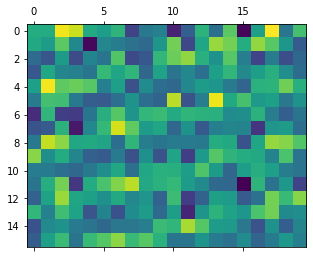

In [66]:
plt.matshow(np.reshape(h,(Nf,Nlags)))

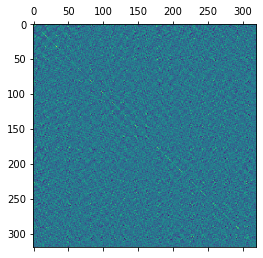

In [67]:
plt.matshow(np.reshape(J,(Nf*Nlags,Nf*Nlags)))

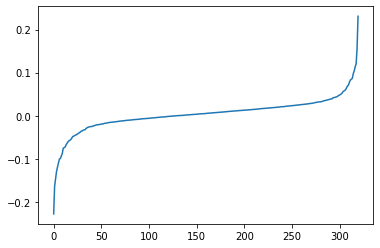

In [68]:
eigenvalues_sorted = sort(V)
plt.plot(eigenvalues_sorted)

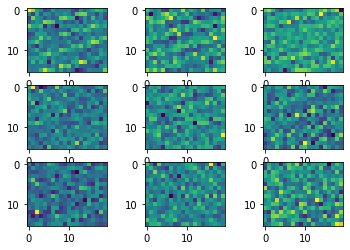

In [106]:
figure()
for i in range(9):
    subplot(3, 3, i+1)
    eig_sorted = D[:,index[i]]
    imshow(reshape(eig_sorted,(Nf,Nlags)))

In [70]:
min(pfinal)

-0.011656373111371842

In [71]:
max(pfinal)

7.561620406794053

In [74]:
(sum(pfinal) - max(pfinal))/(len(pfinal) - 1)

-2.3710361459135724e-06

In [ ]:
print(np.shape(np.log(np.array(f0))))

In [ ]:
print(np.shape((1 - np.array(trainresp))))

In [ ]:
p = np.matrix(p)
    
    #get number of samples and dimensionality of stimulus
    Nsamples = np.size(stim,0)
    Ndim = np.size(stim,1)
    
    #unpack p: (var names match names in Fitzgerald paper)
    a = p[0,0]
    h = p[0,1:Ndim+1]
    
    #case: second order calculation --> need J
    if(order > 1):
        J_squash = p[0,Ndim+1:Ndim+2+Ndim**2]   
        #reshape J into Ndim x Ndim matrix:
        J = np.reshape(J_squash,(Ndim,Ndim)) #matrix?
    
    if(order == 1):
        f1 = 1 + np.exp(a + stim * h.T)
        f0 = 1 + np.exp(-a - stim * h.T)
    else:
        f1 = 1 + np.exp(np.array(np.ones(Nsamples)*a) + np.array(stim * h.T)[:,0] + (np.sum(np.array(stim)*np.array(stim*J),1)))
        f0 = 1 + np.exp(-np.array(np.ones(Nsamples)*a) - np.array(stim * h.T)[:,0] - (np.sum(np.array(stim)*np.array(stim*J),1)))
    
    #print 'f1'
    #print f1
    F1 = np.array(resp)[:,0] * np.log(np.array(f1))
    #print F1
    #print 'f0'
    #print f0
    F0 = (1 - np.array(resp)[:,0]) * np.log(np.array(f0)) 
    #print F0
    F1[np.isnan(F1)] = 0
    F0[np.isnan(F0)] = 0
    #print 'ave entropy'
    #print np.mean(F0 + F1)
    return np.mean(F0 + F1)   # f = mean(F0 + F1)

In [ ]:
def dlinmin():
    TOL = 2.0e-4
    nrfunc = func 
    nrdfun = dfunc 
    pcom   = p 
    xicom  = xi 
    
    ax = 0.0       #Initial guess for brackets
    xx = 0.2       #2*rand();%2.0;
    
    ftemp = @f1dim
    ftemp2 = @df1dim
    
    
    
    


In [ ]:
function [p, xi, fret] = dlinmin(p, xi, func, dfunc, stim, resp, order, avgs)
 
TOL    = 2.0e-4;  % Tolerance passed to brent. 

global pcom xicom nrfunc nrdfun; 
nrfunc = func; 
nrdfun = dfunc; 
pcom   = p; 
xicom  = xi; 
 
ax     = 0.0;  % Initial guess for brackets. 
xx     = .2;%2*rand();%2.0; 

ftemp=@f1dim;
ftemp2=@df1dim;

[ax, xx, bx, fa1, fc1, fb1] = mnbrak(ax, xx, ftemp, stim, resp, order, avgs);
%[ax,xx,bx]
%plotalonglinemin(ax,bx,ftemp);
[fret, xmin] = dbrent(ax,xx,bx,ftemp,ftemp2,TOL, stim, resp, order, avgs); 
%xmin
%plot([xmin],[fret],'ro','LineWidth',7); 
%drawnow;
%hold off;
xi     = xi.*xmin;
p      = p + xi;

In [ ]:
from math import *
def frprmn():
    ITMAX = 1000
    fp = eval(func, p, stim, resp, order)
    xi = eval(dfunc, p, stim, avgs, order)    
    exitCondition = 0
    g  = -xi
    h  = g
    xi = g
    besttest = 1000
    flist=[]
    ftestlist=[]
    tally = 0
    
    # Loop over iterations of minimization
    for its in range(ITMAX):
        display('Iteration' str(its))
        
        

In [ ]:
function [pbest, flist, ftestlist] = frprmn(p, func, dfunc, stim, resp, teststim, testresp, order, avgs, fittype)

ITMAX = 1000;
fp = feval(func, p, stim, resp, order);
xi = feval(dfunc, p, stim, avgs, order);
exitCondition = 0;
g  = -xi;
h  = g;
xi = g;
besttest = 1000;
flist=[];
ftestlist=[];
tally = 0;

% Loop over iterations of minimization
for its=1:ITMAX,
    disp(['Iteration ' num2str(its)]);
  
    [p, xi, fret] = dlinmin(p, xi, func, dfunc, stim, resp, order, avgs);
    flist(its)=fret;
    if fittype==0
        ftestlist(its)=feval(func, p, teststim, testresp, order);
    end
    
    
%    figure(1)
%    plot(flist)
%    if fittype==0
%        hold on
%        plot(ftestlist,'r')
%        hold off
%    end
%    drawnow

    
    if fittype==0
        
        if ftestlist(its)<besttest*.999999  || its<=2     % train validation test validation overfitting line goes up
            besttest = ftestlist(its);
            pbest = p;
            tally=0;
        else
            tally = tally+1;
        end
        
        if tally==10 || its==400
            disp(tally)
            disp(its)
            disp('min of test set found');
            exitCondition = 1;
            break;
        end
        
    else
        [Nsamples,Ndim] = size(stim);
        J = reshape(p(Ndim+2:Ndim+1+Ndim^2),[Ndim,Ndim]);
        [evecs,evals]=eig(J);
        [EV,inds] = sort((diag(evals)));
        disp(num2str([min(EV) , max(EV)]));
        if its==200
            pbest = p;
            disp('stopping algorithm');
            exitCondition = 1;
            break;
        end
    end
    
    xi = feval(dfunc, p, stim, avgs, order);
    gg = sum(g.^2);
    dgg = sum( (xi + g).*xi );   % This statement for Polak-Ribiere
    % dgg = sum( xi.^2);         % This statement for Fletcher-Reeves
    if gg == 0,            % Unlikely.  If gradient is exactly zero then
        exitCondition = 2;   % we are already done.
        disp('Gradient equal to zero, exiting frprmn.');
        break;
    end
    gam = dgg/gg;
    g = -xi;
    h = g + gam.*h;
    xi = h;
end
if exitCondition == 0,
    disp('Too many iterations in frprmn');
end

In [ ]:
order1 = 2
pfinal = mnefit(trainstim,trainresp,order1)

In [ ]:
function df = dlogloss(p, stim, avgs, order)

[Nsamples,Ndim] = size(stim);

ptemp = p(2:Ndim+1);
if order>1
    J = reshape(p(Ndim+2:Ndim+1+Ndim^2),[Ndim,Ndim]);
end

if order==1
    pSpike = 1./(1+exp(p(1)+stim*ptemp'));  % Nsamples x 1
    averages = mean(pSpike);
    averages(2:Ndim+1,1) = stim'*pSpike/Nsamples;
elseif order==2
    pSpike = 1./(1+exp(p(1)+stim*ptemp'+sum(stim.*(stim*J),2)));  % Nsamples x 1
    averages = mean(pSpike);
    averages(2:Ndim+1,1) = stim'*pSpike./Nsamples;
    temp = stim'*(repmat(pSpike,[1,Ndim]).*stim)./Nsamples;  % Ndim x Ndim
    temp = reshape(temp,[Ndim^2,1]);
    averages(Ndim+2:Ndim+1+Ndim^2) = temp;    
end
%display(size(pSpike))
%display(size(averages))
%display(size(avgs))

df = (avgs - averages)';  % 1 x Ndim
%display(df)

In [ ]:
#import MNEfit as mnefit
#import scipy as sp
#import scipy.optimize as opt
#mport logLossFuncs as LLF
#pfinal = opt.fmin_cg(logLoss,pstart,fprime=dlogLoss)

In [ ]:
np.shape((1.0*stim.T*resp)/(Nsamples*1.0))

In [ ]:



#initialize params:
pstart = sp.log(1/avgs[0,0] - 1)
pstart = sp.hstack((pstart,(.001*(2*sp.random.rand(Ndim)-1))))
if(order > 1):
    temp = .0005*(2*sp.random.rand(Ndim,Ndim)-1)
    pstart = sp.hstack((pstart,sp.reshape(temp+temp.T,(1,Ndim**2))[0]))


In [ ]:
b = np.multiply(a,trainstim)

In [ ]:
c = np.dot(np.transpose(trainstim),b)

In [ ]:
np.shape(c)

In [ ]:
np.shape(np.transpose(trainresp)*trainstim)

In [ ]:
#####
print(np.shape(trainstim))
print(np.shape(teststim))
print(np.shape(masterstim))

In [ ]:
##### 
resp_mean

In [ ]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print ("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print ("Toc: start time not set")

In [ ]:
for jack in range(njack):    #loop over all njacks to resample and fix outliers in tsne    
    Ntest = int(master_samples/njack)    #  rounds the Ntest to the nearest integers 
    ind = range(jack*Ntest,(jack+1)*Ntest)
    teststim = masterstim[jack*Ntest : (jack+1)*Ntest, :]
    testresp = masterresp[jack*Ntest : (jack+1)*Ntest]
    trainstim = np.delete(masterstim, ind, axis = 0) 
    trainresp = np.delete(masterresp, ind)
    
    # Start optimization: look for highest P(resp/stim)=1/(1+exp(a+sh+s^t*J*s)^-1
    display('Starting optimization')
    tic()
    #celltype = '';  #ignore this
    
    #MNEfit(stim, resp, teststim, testresp, celltype, cellnum, jack, order, Nd, fittype);
    [Nsamples_2,Ndim_2] = np.shape(trainstim)
    psp = np.mean(trainresp)   #constant parameter a
    ??????avg = (np.transpose(trainstim)*trainresp)/Nsamples_2  # h: linear
    
avg_1 = mean(avg,2); 
avgs = [psp;avg_1]; % J: non-linear 
if order>1
    avgsqrd = trainstim'*(repmat(trainresp,[1,Ndim_2]).*trainstim)/Nsamples_2;  % Ndim x Ndim (320x320)
    avgsqrd = reshape(avgsqrd,[Ndim_2^2,1]); 
    avgs = [avgs;avgsqrd]; % avgs= [a,h,J]
end

% Initialize parameters. This is to set a random staring point on optimization curve. 

pstart = log(1/avgs(1)-1);  %pstart(a)
pstart(2:Ndim_2+1) = .001*(2*rand([1,Ndim_2])-1); %pstart(h)
if order>1
    temp = .001*(2*rand([Ndim_2,Ndim_2])-1); % pstart(J)
    pstart(Ndim_2+2:length(pstart)+Ndim_2^2) = reshape((temp+temp'),[1,Ndim_2^2]);
    clear temp;
end

% Run conjugate gradient algorithm 
%Conjugate= method of optimization to not to miss the min on curve
%frprmn= Get derivative to locate the global minima of variables 
%logloss=Near probability model to a set of binary labeled examples. 
%dloggloss=Gradient of the log loss function

% Pass pstart (intial number) to logloss and dlogloss...for every point to get pfinal
pfinal = frprmn(pstart, @logloss, @dlogloss, trainstim, trainresp, teststim, testresp, order, avgs, Nd, fittype);

%Save results
       
save(['B952_P1S1_cell' num2str(cellnum) '_5stims' '_Nlags' num2str(Nlags) '_nfft128_Nf16' '_jack_' num2str(jack) '_of_' num2str(njack) '.mat'],'pfinal');
  
%end

disp(['Optimization took ' num2str(toc/60) ' minutes']);

% This a, h,J are coresponding to pbest=min of test set
h=pfinal(2:Nlags*Nf+1); % h=2:321

J=pfinal(Nlags*Nf+2:end); % this is the covariance matrix J=322:end 

[V,D] = eig(reshape(J,Nlags*Nf,Nlags*Nf)); %[V,D] = eig(A) produces a diagonal matrix D of eigenvalues and eigenvectors 

%Plot the results and save the figures
figure
subplot(3,3,1)
imagesc(reshape(h,Nf,Nlags))
axis xy
title('h')
xlabel('t');
ylabel('f');
 
subplot(3,3,2)
imagesc(reshape(J,Nlags*Nf,Nlags*Nf))
axis xy
axis square
title('J')

subplot(3,3,3)
eigenvalues = diag(D);
[eigenvalues_sorted,index] = sort(eigenvalues); %sorts the elements of eigenvalues in ascending order.
plot(eigenvalues_sorted,'o');
title('J Eigvalue Matrix')


subplot(3,3,4)
eig_sorted_1 = V(:,index(1)); 
imagesc(reshape(eig_sorted_1,Nf,Nlags))
axis xy
title('eig vect 1')
xlabel('t');
ylabel('f');

subplot(3,3,5)
eig_sorted_2=V(:,index(2)); 
imagesc(reshape(eig_sorted_2,Nf,Nlags))
axis xy
title('eig vect 2')
xlabel('t');
ylabel('f');

subplot(3,3,6)
eig_sorted_3=V(:,index(3)); 
imagesc(reshape(eig_sorted_3,Nf,Nlags))
axis xy
title('eig vect 3')
xlabel('t');
ylabel('f');

subplot(3,3,7)
eig_sorted_end=V(:,index(end));
imagesc(reshape(eig_sorted_end,Nf,Nlags))
axis xy
title('eig vect end')
xlabel('t');
ylabel('f');

subplot(3,3,8)
eig_sorted_end_1=V(:,index(end-1));
imagesc(reshape(eig_sorted_end_1,Nf,Nlags))
axis xy
title('eig vect end-1')
xlabel('t');
ylabel('f');

subplot(3,3,9)
eig_sorted_end_2=V(:,index(end-2));
imagesc(reshape(eig_sorted_end_2,Nf,Nlags))
axis xy
title('eig vect end-2')
xlabel('t');
ylabel('f');

figure_name = (['B952_' num2str(cellnum) 'your figure name' '_Nlags' num2str(Nlags) '_nfft128_Nf16' '_jack_' num2str(jack) '_of_' num2str(njack)]); 
end

In [ ]:
def plot_raster_cell__stim(spikes, trials, clusterID,
                          stim, period, rec, fs, ax=None, stim_ref='stim', **kwargs):
    stim_trials = trials[trials['stimulus'] == stim]
    ntrials = len(stim_trials)
    stim_starts = stim_trials['time_samples'].values
    stim_ends = stim_trials['stimulus_end'].values
    stim_end_seconds = np.unique((stim_ends - stim_starts) / fs)[0]
    if stim_ref == 'stim':
        window = [period[0], stim_end_seconds + period[1]]
    elif stim_ref == 'abs':
        window = [period[0], period[1]]
    raster_data = []
    for trial, start in enumerate(stim_starts):
        sptrain = get_spiketrain(rec, start, clusterID, spikes, window, fs)
        raster_data.append(sptrain)
    ax = do_raster(raster_data, window, [0, stim_end_seconds], ntrials, ax, **kwargs)
    return ax

In [ ]:
#

In [ ]:
import scipy.optimize as opt
import numpy as np

def log_loss(p, stim, resp, order):
    #get number of samples and dimensionality of stimulus
    Nsamples, Ndim = stim.shape
    resp = np.reshape(resp, (-1))
    
    #unpack p: (var names match names in Fitzgerald paper)
    a = p[0]
    h = p[1:Ndim+1].T
    
    #case: second order calculation --> need J
    if order > 1:
        #reshape J into Ndim x Ndim matrix:
        J = np.reshape(p[Ndim+1:Ndim+1+Ndim**2], (Ndim,Ndim)).T
    
    if order == 1:
        f1 = 1 + np.exp( a + stim.dot(h))
        f0 = 1 + np.exp(-a - stim.dot(h))
    else:
        f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
        f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
    
    F1 = resp * np.log(f1)
    F0 = (1 - resp) * np.log(f0)
    F1[np.isnan(F1)] = 0
    F0[np.isnan(F0)] = 0
    return np.mean(F0 + F1)

def d_log_loss(p,stim,avgs,order):
    #get number of samples and dimensionality of stimulus
    Nsamples, Ndim = stim.shape
    
    #unpack p: (var names match names in Fitzgerald paper)
    a = p[0]
    h = p[1:Ndim+1].T
    
    #case: second order calculation --> need J
    if order > 1:
        J = np.reshape(p[Ndim+1:Ndim+1+Ndim**2], (Ndim,Ndim))
        
    if order == 1:
        pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h))) #Nsamples x 1
        averages = np.hstack((np.mean(pSpike), stim.T.dot(pSpike) / Nsamples))
    elif order == 2:
        
        pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
        averages = np.zeros(1+Ndim+Ndim**2)
        averages[0] = np.mean(pSpike)
        averages[1:Ndim+1] = stim.T.dot(pSpike) / Nsamples #ave number of spikes for each stim dimension
        
        temp = (stim.T.dot(np.tile(np.reshape(pSpike, (Nsamples, 1)), (1,Ndim)) * stim)) / Nsamples  #ave number of spikes for each stim correlation
        temp = np.reshape(temp,[Ndim**2,1])
        averages[Ndim+1:Ndim+1+Ndim**2] = np.reshape(temp, Ndim**2)
        
    return (np.squeeze(avgs) - averages)

def constrained_averages(stim, resp, order):
    Nsamples, Ndim = stim.shape
    psp = np.mean(resp) #spike probability
    avg = stim.T.dot(resp) / Nsamples
    avgs = np.vstack((psp,avg))
    if order > 1 :
        avgsqrd = stim.T.dot(np.tile(resp, (1,Ndim)) * stim) / Nsamples
        avgsqrd = np.reshape(avgsqrd,(Ndim**2,1))
        avgs = np.vstack((avgs,avgsqrd))
    return avgs

def rand_pstart(avgs, order, Ndim):
    pstart = np.log(1.0 / avgs[0] - 1.0)
    pstart = np.hstack((pstart,(.001*(2*np.random.rand(Ndim)-1))))
    if order > 1:
        temp = .0005 * (2 * np.random.rand(Ndim,Ndim) - 1) # for symmetry
        pstart = np.hstack((pstart, np.reshape(temp + temp.T, Ndim**2)))
    return pstart
    
class IterCounter(object):
    def __init__(self):
        self.n_iters = 1
        print '{0:5s}'.format('Iters')
    def callback(self, xk):
        print '{0:5d}'.format(self.n_iters)
        self.n_iters += 1
    
class OverfitException(Exception):
    def __init__(self, p):
        self.p = p
        
class OverfitStopper(object):
    def __init__(self, test_stim, test_resp, order):
        self.test_stim = test_stim
        self.test_resp = test_resp
        self.order = order
        self.n_iters = 1
        self.best_ll = np.inf
        self.best_p = 0
        self.test_tally = 0
        print '{0:5s}   {1:5s}   {2:9s}'.format('Iters', 'tally', 'll(test)')
        
    def callback(self, pk):
        ll_test_k = log_loss(pk, self.test_stim, self.test_resp, self.order)
        print '{0:5d}   {1:5d}   {2: 3.6f}'.format(self.n_iters, self.test_tally, ll_test_k)
        if self.n_iters <= 2 or ll_test_k < self.best_ll:
            self.best_ll = ll_test_k
            self.best_p = pk
            self.test_tally = 0
        else:
            self.test_tally += 1
        
        if self.test_tally >= 10:
            print 'minimum of test set found'
            raise OverfitException(self.best_p)
        
        self.n_iters += 1

def MNEfit(stim, resp, order, pstart=None):

    stim = np.array(stim, dtype=float)
    resp = np.array(resp, dtype=float)

    Nsamples, Ndim = stim.shape
    avgs = constrained_averages(stim, resp, order)
    
    if pstart is None: #initialize params:
        pstart = rand_pstart(avgs, order, Ndim)
    
    #redefine functions with fixed vals:
    def logLoss(p):
        return log_loss(p, stim, resp, order)
    def dlogLoss(p):
        return d_log_loss(p, stim, avgs, order)
    
    pfinal = opt.fmin_cg(logLoss, pstart, fprime=dlogLoss, 
                         callback=IterCounter().callback, maxiter=200)
    
    return pfinal

def MNEfit_jackknives(stim, resp, order, pstart=None, jackknives=4, shuffle=True):

    stim = np.array(stim, dtype=float)
    resp = np.array(resp, dtype=float)
    
    Nsamples, Ndim = stim.shape #TODO: rename Nsamples to n_samples
    assert resp.shape[0] == Nsamples
    assert resp.shape[1] == 1
    
    if shuffle:
        shuffled_indxs = range(Nsamples)
        np.random.shuffle(shuffled_indxs)
        stim = stim[shuffled_indxs,:]
        resp = resp[shuffled_indxs,:]
    
    for jackknife in range(jackknives):
        test_stim = stim[jackknife::jackknives,:]
        test_resp = resp[jackknife::jackknives,:]
        train_stim = stim[np.mod(np.arange(Nsamples)-jackknife, jackknives) != 0,:]
        train_resp = resp[np.mod(np.arange(Nsamples)-jackknife, jackknives) != 0,:]
        
        avgs = constrained_averages(train_stim, train_resp, order)

        if pstart is None: #initialize params:
            pstart = rand_pstart(avgs, order, Ndim)
            
        #redefine functions with fixed vals:
        def logLoss(p):
            return log_loss(p, train_stim, train_resp, order)
        def dlogLoss(p):
            return d_log_loss(p, train_stim, avgs, order)

        try:
            pfinal = opt.fmin_cg(logLoss, pstart, fprime=dlogLoss,
                                 callback=OverfitStopper(test_stim, test_resp, order).callback,
                                 maxiter=200)
        except OverfitException as e:
            pfinal = e.p
        
        if jackknife == 0:
            all_pfinals = np.zeros((jackknives, len(pstart)))
        all_pfinals[jackknife, :] = pfinal
    
    return all_pfinals